In [1]:
from sqlalchemy import create_engine
import os
import numpy as np
import pandas as pd
from dotenv import load_dotenv

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)

def create_connection():

    load_dotenv()
    host = os.environ.get('DB_DESTINATION_HOST')
    port = os.environ.get('DB_DESTINATION_PORT')
    db = os.environ.get('DB_DESTINATION_NAME')
    username = os.environ.get('DB_DESTINATION_USER')
    password = os.environ.get('DB_DESTINATION_PASSWORD')

    conn = create_engine(f'postgresql://{username}:{password}@{host}:{port}/{db}')
    return conn

# установите соединение с базой
conn = create_connection()


In [4]:
data_unique = pd.read_sql('''
                           select f.id flat_id,f.floor,f.is_apartment apartment,f.kitchen_area,f.living_area,f.rooms,
        f.studio,f.total_area,f.price,f.building_id,
        b.build_year,b.building_type_int building_type,b.latitude,b.longitude,
        b.ceiling_height,b.flats_count,b.floors_total,b.has_elevator
        from flats as f
        join buildings as b on f.building_id=b.id
                   ''', conn)
data_unique
data_unique.shape

(141362, 18)

In [5]:
print(data_unique.dtypes)

flat_id             int64
floor               int64
apartment            bool
kitchen_area      float64
living_area       float64
rooms               int64
studio               bool
total_area        float64
price               int64
building_id         int64
build_year          int64
building_type       int64
latitude          float64
longitude         float64
ceiling_height    float64
flats_count         int64
floors_total        int64
has_elevator         bool
dtype: object


In [28]:
unique_counts = data_unique.nunique()
print(unique_counts)

id                   141362
floor                    56
is_apartment              2
kitchen_area           1036
living_area            2345
rooms                    14
studio                    1
total_area             3358
price                  8384
building_id           24620
build_year              118
building_type_int         7
latitude              15720
longitude             15271
ceiling_height           77
flats_count             706
floors_total             64
has_elevator              2
dtype: int64


In [29]:
is_duplicated_id = data_unique.duplicated(subset=['id'], keep=False)
# параметр keep = False приводит к тому, что и оригинал, и дубликат помечаются как объект с дубликатом
print(sum(is_duplicated_id)) 

0


In [30]:
feature_cols = data_unique.columns.difference(['id']).tolist()
print(feature_cols)
is_duplicated_features = data_unique.duplicated(subset=feature_cols,keep=False)
# print(is_duplicated_features)
#data["is_duplicated_features"]=is_duplicated_features
#print(data)
print(len(data_unique[is_duplicated_features]))

['build_year', 'building_id', 'building_type_int', 'ceiling_height', 'flats_count', 'floor', 'floors_total', 'has_elevator', 'is_apartment', 'kitchen_area', 'latitude', 'living_area', 'longitude', 'price', 'rooms', 'studio', 'total_area']
17425


In [31]:
print(data_unique[is_duplicated_features].sort_values(feature_cols)) 

            id  floor  is_apartment  kitchen_area  living_area  rooms  studio  total_area     price  building_id  build_year  building_type_int   latitude  longitude  ceiling_height  flats_count  floors_total  has_elevator
52640    52640      3         False           0.0          0.0      4   False  120.000000  60000000            3        1901                  1  55.759594  37.646488             3.2           26             4         False
54009    54009      3         False           0.0          0.0      4   False  120.000000  60000000            3        1901                  1  55.759594  37.646488             3.2           26             4         False
90882    90882      4         False          11.0         48.0      2   False   63.000000  28000000            4        1902                  1  55.748661  37.656487             3.0           32             4         False
122183  122183      4         False          11.0         48.0      2   False   63.000000  28000000         

In [33]:
# print(f'data shape = {df_cleaned.shape}')

data shape = (123937, 18)


In [46]:
# sql = '''
# select distinct studio from flats
# '''

# sql = '''
# select f.*,b.* from flats f
# join buildings as b on f.building_id=b.id
# '''

sql='''
select f.id,f.floor,f.is_apartment,f.kitchen_area,f.living_area,f.rooms,
f.studio,f.total_area,f.price,f.building_id,
b.build_year,b.building_type_int,b.latitude,b.longitude,
b.ceiling_height,b.flats_count,b.floors_total,b.has_elevator 
from flats as f
join buildings as b on f.building_id=b.id'''

studio = pd.read_sql(sql, conn)

studio.shape

(141362, 18)

In [49]:
unique_counts = studio.nunique()
print(studio.shape)
print(unique_counts)

(141362, 18)
id                   141362
floor                    56
is_apartment              2
kitchen_area           1036
living_area            2345
rooms                    14
studio                    1
total_area             3358
price                  8384
building_id           24620
build_year              118
building_type_int         7
latitude              15720
longitude             15271
ceiling_height           77
flats_count             706
floors_total             64
has_elevator              2
dtype: int64


In [50]:
data_filtered = studio.loc[:, studio.nunique() > 1]

# Вывод результата
print("Исходный датафрейм:")
print(studio)
print("\nДатафрейм после удаления столбцов с одним уникальным значением:")
print(data_filtered)

Исходный датафрейм:
            id  floor  is_apartment  kitchen_area  living_area  rooms  studio  total_area     price  building_id  build_year  building_type_int   latitude  longitude  ceiling_height  flats_count  floors_total  has_elevator
0            0      9         False          9.90    19.900000      1   False   35.099998   9500000         6220        1965                  6  55.717113  37.781120            2.64           84            12          True
1            1      7         False          0.00    16.600000      1   False   43.000000  13500000        18012        2001                  2  55.794849  37.608013            3.00           97            10          True
2            2      9         False          9.00    32.000000      2   False   56.000000  13500000        17821        2000                  4  55.740040  37.761742            2.70           80            10          True
3            3      1         False         10.10    43.099998      3   False   76.00000

In [52]:
# Определение количества строк
num_rows = data_filtered.shape[0]

# Поиск столбцов с уникальными значениями, равными количеству строк
unique_value_columns = data_filtered.columns[data_filtered.nunique() == num_rows]

# Вывод столбцов с уникальными значениями
print("Столбцы с уникальными значениями, равными количеству строк:")
print(unique_value_columns.tolist())
feature_cols = data_unique.columns.difference(unique_value_columns.tolist()).tolist()
# Удаление таких столбцов для поиска дублирующихся строк
data_without_unique = data_filtered.drop(columns=unique_value_columns)

# Находим дублирующиеся строки в оставшихся столбцах
duplicate_rows = data_without_unique[data_without_unique.duplicated(keep=False)].sort_values(feature_cols)

# Подсчитываем количество дублирующихся строк
duplicate_count = duplicate_rows.shape[0]

# Вывод результатов
print(f"\nКоличество дублирующихся строк в оставшихся столбцах: {duplicate_count}")
print("Дублирующиеся строки:")
print(duplicate_rows)

Столбцы с уникальными значениями, равными количеству строк:
['id']

Количество дублирующихся строк в оставшихся столбцах: 17425
Дублирующиеся строки:
        floor  is_apartment  kitchen_area  living_area  rooms  total_area     price  building_id  build_year  building_type_int   latitude  longitude  ceiling_height  flats_count  floors_total  has_elevator
52640       3         False           0.0          0.0      4  120.000000  60000000            3        1901                  1  55.759594  37.646488             3.2           26             4         False
54009       3         False           0.0          0.0      4  120.000000  60000000            3        1901                  1  55.759594  37.646488             3.2           26             4         False
90882       4         False          11.0         48.0      2   63.000000  28000000            4        1902                  1  55.748661  37.656487             3.0           32             4         False
122183      4         

In [53]:
feature_cols = data_filtered.columns.difference(['id']).tolist()
data_unique = data_filtered.drop_duplicates(subset=feature_cols)

# Вывод результата
print("Датафрейм с уникальными строками (дубликаты удалены):")
print(data_unique)

Датафрейм с уникальными строками (дубликаты удалены):
            id  floor  is_apartment  kitchen_area  living_area  rooms  total_area     price  building_id  build_year  building_type_int   latitude  longitude  ceiling_height  flats_count  floors_total  has_elevator
0            0      9         False          9.90    19.900000      1   35.099998   9500000         6220        1965                  6  55.717113  37.781120            2.64           84            12          True
1            1      7         False          0.00    16.600000      1   43.000000  13500000        18012        2001                  2  55.794849  37.608013            3.00           97            10          True
2            2      9         False          9.00    32.000000      2   56.000000  13500000        17821        2000                  4  55.740040  37.761742            2.70           80            10          True
3            3      1         False         10.10    43.099998      3   76.000000  200

In [54]:
features = data_unique.drop(columns=['id'])
data_types = features.dtypes
type_counts = data_types.value_counts()

print(data_types)
print(type_counts)
print(features.shape)

floor                  int64
is_apartment            bool
kitchen_area         float64
living_area          float64
rooms                  int64
total_area           float64
price                  int64
building_id            int64
build_year             int64
building_type_int      int64
latitude             float64
longitude            float64
ceiling_height       float64
flats_count            int64
floors_total           int64
has_elevator            bool
dtype: object
int64      8
float64    6
bool       2
Name: count, dtype: int64
(132246, 16)


In [55]:
num_features = features.select_dtypes(include=['float64', 'int64'])
# bool_features = features.select_dtypes(include='bool')
bool_features = features.select_dtypes(include='bool')

# Подсчет значений True и False для каждого булевого столбца
for col in bool_features:
    true_count = bool_features[col].sum()  # Количество True
    false_count = (~bool_features[col]).sum()  # Количество False
    print(f"Столбец '{col}': True: {true_count}, False: {false_count}")


# print(bool_features)
# print(other_cat_features)
print(num_features)

Столбец 'is_apartment': True: 1270, False: 130976
Столбец 'has_elevator': True: 118607, False: 13639
        floor  kitchen_area  living_area  rooms  total_area     price  building_id  build_year  building_type_int   latitude  longitude  ceiling_height  flats_count  floors_total
0           9          9.90    19.900000      1   35.099998   9500000         6220        1965                  6  55.717113  37.781120            2.64           84            12
1           7          0.00    16.600000      1   43.000000  13500000        18012        2001                  2  55.794849  37.608013            3.00           97            10
2           9          9.00    32.000000      2   56.000000  13500000        17821        2000                  4  55.740040  37.761742            2.70           80            10
3           1         10.10    43.099998      3   76.000000  20000000        18579        2002                  4  55.672016  37.570877            2.64          771            17
4   

In [56]:
max_price = data_unique['price'].max()

# Вычислить 90% от максимального значения
threshold = 0.9 * max_price

# Отфильтровать строки, где 'price' > 0.9 * max(price)
highest_price = data_unique[data_unique['price'] > threshold]

# Вывод результата
print("Строки, где 'price' > 90% от максимального значения:")
print(highest_price)

Строки, где 'price' > 90% от максимального значения:
          id  floor  is_apartment  kitchen_area  living_area  rooms  total_area       price  building_id  build_year  building_type_int   latitude  longitude  ceiling_height  flats_count  floors_total  has_elevator
40855  40855      2         False      6.000000         27.9      2        45.0  9200000000        10733        1974                  4  55.578274  37.647091            2.65          214             9          True
83773  83773      6         False      8.000000         22.0      2        37.0  9799999488         6108        1965                  4  55.842663  37.427437            2.64           72             9          True
85787  85787     25         False     22.299999        125.0      5       220.0  9873737728        19982        2006                  2  55.652802  37.474201            3.10          219            33          True


In [57]:
data_unique.isnull().sum()

id                   0
floor                0
is_apartment         0
kitchen_area         0
living_area          0
rooms                0
total_area           0
price                0
building_id          0
build_year           0
building_type_int    0
latitude             0
longitude            0
ceiling_height       0
flats_count          0
floors_total         0
has_elevator         0
dtype: int64

count    1.322460e+05
mean     1.933210e+07
std      6.757713e+07
min      1.100000e+01
25%      8.900000e+06
50%      1.180000e+07
75%      1.685000e+07
max      9.873738e+09
Name: price, dtype: float64

<Axes: xlabel='price', ylabel='Count'>

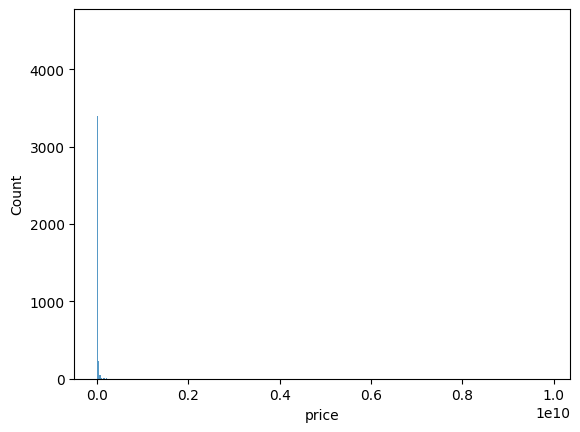

In [58]:
import seaborn as sns
display(num_features['price'].describe())
display(sns.histplot(num_features['price']))

In [62]:
num_cols = data_unique.select_dtypes(['float','int']).columns
threshold = 0.45
potential_outliers = pd.DataFrame()

for col in num_cols:
	Q1 = data_unique[col].quantile(0.25)
	Q3 = data_unique[col].quantile(0.75)
	IQR = Q3 - Q1
	margin = threshold * IQR
	lower = Q1 - margin
	upper = Q3 + margin
	potential_outliers[col] = ~data_unique[col].between(lower, upper)

outliers = potential_outliers.any(axis=1)

print(data_unique[outliers])


            id  floor  is_apartment  kitchen_area  living_area  rooms  total_area     price  building_id  build_year  building_type_int   latitude  longitude  ceiling_height  flats_count  floors_total  has_elevator
0            0      9         False          9.90    19.900000      1   35.099998   9500000         6220        1965                  6  55.717113  37.781120            2.64           84            12          True
1            1      7         False          0.00    16.600000      1   43.000000  13500000        18012        2001                  2  55.794849  37.608013            3.00           97            10          True
2            2      9         False          9.00    32.000000      2   56.000000  13500000        17821        2000                  4  55.740040  37.761742            2.70           80            10          True
3            3      1         False         10.10    43.099998      3   76.000000  20000000        18579        2002                  4  55.